<!-- dom:TITLE: Week 47: Support Vector Machines -->
# Week 47: Support Vector Machines
<!-- dom:AUTHOR: Morten Hjorth-Jensen at Department of Physics, University of Oslo & Department of Physics and Astronomy and National Superconducting Cyclotron Laboratory, Michigan State University -->
<!-- Author: -->  
**Morten Hjorth-Jensen**, Department of Physics, University of Oslo and Department of Physics and Astronomy and National Superconducting Cyclotron Laboratory, Michigan State University

Date: **Nov 20, 2020**

Copyright 1999-2020, Morten Hjorth-Jensen. Released under CC Attribution-NonCommercial 4.0 license



## Overview of week 47

* **Thursday**: Support Vector Machines, classification and regression. [Video of Lecture](https://www.uio.no/studier/emner/matnat/fys/FYS-STK4155/h20/forelesningsvideoer/LectureNovember19.mp4?vrtx=view-as-webpage)

* **Friday**: Workshop on project 3 (first lecture), Support Vector Machines (second Lecture)

Geron's chapter 5. Chapter 12 (sections 12.1-12.3 are the most relevant ones)  of Hastie et al contains also a good discussion.

[See overview video on Support Vector Machines](https://www.youtube.com/watch?v=efR1C6CvhmE&ab_channel=StatQuestwithJoshStarmer). See also [this video](https://www.youtube.com/watch?v=N1vOgolbjSc&ab_channel=AliceZhao).


## Thursday

We start with our final topic this semester, Support Vector Machines

## Friday

Friday's lecture is split in two parts. The first lecture is deveoted to a presentation of possible data sets and projects for project 3. The second lecture continues with support vector machines. It may happen that we will need parts of the second lecture as well for the project ideas.

## Workshop plan Friday (first lecture)

Here are the various projects that will be presented during the first lecture (and possibly parts of the second lecture as well). *Titles are tentative*.   Talks are approx 5-10 mins with roughly 5 minutes for discussions.

* Maria Emine Nylund: **Lego Bricks Classifier**

* Fabio Rodrigues Pereira: **Financial Machine Learning**

* Markus Borud Pettersen: **Machine Learning and Brain Grid Cells**

* Jing Sun and Endrias Getachew Asgedom: **Machine learning-based approaches to denoising microseismic data**

* Felicia Jacobsen: **Analysis of Breast Cancer Data**

* Simon Elias Schrader: **Predicting atomization energies of molecules**

* Varvara Bazilova and Sergio Andres Diaz Mesa: **Glacier Mapping and Machine Learning**

* Gert Werner Kluge, Hanna Alida Fossen Hardersen and Sushma Sharma Adhikari: **Gamma ray signals stemming from dark matter in the galactic center**

## Support Vector Machines, overarching aims

A Support Vector Machine (SVM) is a very powerful and versatile
Machine Learning method, capable of performing linear or nonlinear
classification, regression, and even outlier detection. It is one of
the most popular models in Machine Learning, and anyone interested in
Machine Learning should have it in their toolbox. SVMs are
particularly well suited for classification of complex but small-sized or
medium-sized datasets.  

The case with two well-separated classes only can be understood in an
intuitive way in terms of lines in a two-dimensional space separating
the two classes.

The basic mathematics behind the SVM is however less familiar to most of us. 
It relies on the definition of hyperplanes and the
definition of a **margin** which separates classes (in case of
classification problems) of variables. It is also used for regression
problems.

With SVMs we distinguish between hard margin and soft margins. The
latter introduces a so-called softening parameter to be discussed
below.  We distinguish also between linear and non-linear
approaches. The latter are the most frequent ones since it is rather
unlikely that we can separate classes easily by say straight lines.

## Hyperplanes and all that

The theory behind support vector machines (SVM hereafter) is based on
the mathematical description of so-called hyperplanes. Let us start
with a two-dimensional case. This will also allow us to introduce our
first SVM examples. These will be tailored to the case of two specific
classes, as displayed in the figure here based on the usage of the petal data.

We assume here that our data set can be well separated into two
domains, where a straight line does the job in the separating the two
classes. Here the two classes are represented by either squares or
circles.

LinearSVC:                    [0.28475098] [[1.05364854 1.09903804]]
SVC:                          [0.31896852] [[1.1203284  1.02625193]]
SGDClassifier(alpha=0.00200): [0.117] [[0.77714169 0.72981762]]


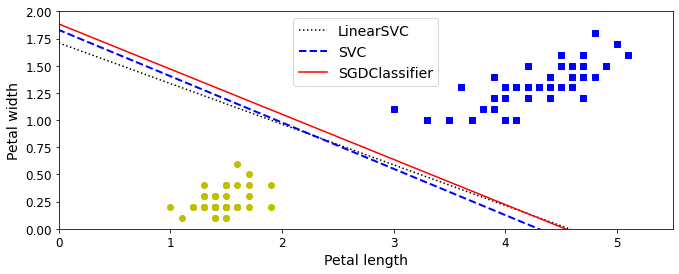

In [1]:
%matplotlib inline

from sklearn import datasets
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]



C = 5
alpha = 1 / (C * len(X))

lin_clf = LinearSVC(loss="hinge", C=C, random_state=42)
svm_clf = SVC(kernel="linear", C=C)
sgd_clf = SGDClassifier(loss="hinge", learning_rate="constant", eta0=0.001, alpha=alpha,
                        max_iter=100000, random_state=42)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lin_clf.fit(X_scaled, y)
svm_clf.fit(X_scaled, y)
sgd_clf.fit(X_scaled, y)

print("LinearSVC:                   ", lin_clf.intercept_, lin_clf.coef_)
print("SVC:                         ", svm_clf.intercept_, svm_clf.coef_)
print("SGDClassifier(alpha={:.5f}):".format(sgd_clf.alpha), sgd_clf.intercept_, sgd_clf.coef_)

# Compute the slope and bias of each decision boundary
w1 = -lin_clf.coef_[0, 0]/lin_clf.coef_[0, 1]
b1 = -lin_clf.intercept_[0]/lin_clf.coef_[0, 1]
w2 = -svm_clf.coef_[0, 0]/svm_clf.coef_[0, 1]
b2 = -svm_clf.intercept_[0]/svm_clf.coef_[0, 1]
w3 = -sgd_clf.coef_[0, 0]/sgd_clf.coef_[0, 1]
b3 = -sgd_clf.intercept_[0]/sgd_clf.coef_[0, 1]

# Transform the decision boundary lines back to the original scale
line1 = scaler.inverse_transform([[-10, -10 * w1 + b1], [10, 10 * w1 + b1]])
line2 = scaler.inverse_transform([[-10, -10 * w2 + b2], [10, 10 * w2 + b2]])
line3 = scaler.inverse_transform([[-10, -10 * w3 + b3], [10, 10 * w3 + b3]])

# Plot all three decision boundaries
plt.figure(figsize=(11, 4))
plt.plot(line1[:, 0], line1[:, 1], "k:", label="LinearSVC")
plt.plot(line2[:, 0], line2[:, 1], "b--", linewidth=2, label="SVC")
plt.plot(line3[:, 0], line3[:, 1], "r-", label="SGDClassifier")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs") # label="Iris-Versicolor"
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo") # label="Iris-Setosa"
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper center", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.show()

## What is a hyperplane?

The aim of the SVM algorithm is to find a hyperplane in a
$p$-dimensional space, where $p$ is the number of features that
distinctly classifies the data points.

In a $p$-dimensional space, a hyperplane is what we call an affine subspace of dimension of $p-1$.
As an example, in two dimension, a hyperplane is simply as straight line while in three dimensions it is 
a two-dimensional subspace, or stated simply, a plane. 

In two dimensions, with the variables $x_1$ and $x_2$, the hyperplane is defined as

$$
b+w_1x_1+w_2x_2=0,
$$

where $b$ is the intercept and $w_1$ and $w_2$ define the elements of a vector orthogonal to the line 
$b+w_1x_1+w_2x_2=0$. 
In two dimensions we define the vectors $\boldsymbol{x} =[x1,x2]$ and $\boldsymbol{w}=[w1,w2]$. 
We can then rewrite the above equation as

$$
\boldsymbol{x}^T\boldsymbol{w}+b=0.
$$

## A $p$-dimensional space of features

We limit ourselves to two classes of outputs $y_i$ and assign these classes the values $y_i = \pm 1$. 
In a $p$-dimensional space of say $p$ features we have a hyperplane defined as

$$
b+wx_1+w_2x_2+\dots +w_px_p=0.
$$

If we define a 
matrix $\boldsymbol{X}=\left[\boldsymbol{x}_1,\boldsymbol{x}_2,\dots, \boldsymbol{x}_p\right]$
of dimension $n\times p$, where $n$ represents the observations for each feature and each vector $x_i$ is a column vector of the matrix $\boldsymbol{X}$,

$$
\boldsymbol{x}_i = \begin{bmatrix} x_{i1} \\ x_{i2} \\ \dots \\ \dots \\ x_{ip} \end{bmatrix}.
$$

If the above condition is not met for a given vector $\boldsymbol{x}_i$ we have

$$
b+w_1x_{i1}+w_2x_{i2}+\dots +w_px_{ip} >0,
$$

if our output $y_i=1$.
In this case we say that $\boldsymbol{x}_i$ lies on one of the sides of the hyperplane and if

$$
b+w_1x_{i1}+w_2x_{i2}+\dots +w_px_{ip} < 0,
$$

for the class of observations $y_i=-1$, 
then $\boldsymbol{x}_i$ lies on the other side. 

Equivalently, for the two classes of observations we have

$$
y_i\left(b+w_1x_{i1}+w_2x_{i2}+\dots +w_px_{ip}\right) > 0.
$$

When we try to separate hyperplanes, if it exists, we can use it to construct a natural classifier: a test observation is assigned a given class depending on which side of the hyperplane it is located.

<!-- !split  -->
## The two-dimensional case

Let us try to develop our intuition about SVMs by limiting ourselves to a two-dimensional
plane.  To separate the two classes of data points, there are many
possible lines (hyperplanes if you prefer a more strict naming)  
that could be chosen. Our objective is to find a
plane that has the maximum margin, i.e the maximum distance between
data points of both classes. Maximizing the margin distance provides
some reinforcement so that future data points can be classified with
more confidence.

What a linear classifier attempts to accomplish is to split the
feature space into two half spaces by placing a hyperplane between the
data points.  This hyperplane will be our decision boundary.  All
points on one side of the plane will belong to class one and all points
on the other side of the plane will belong to the second class two.

Unfortunately there are many ways in which we can place a hyperplane
to divide the data.  Below is an example of two candidate hyperplanes
for our data sample.

## Getting into the details

Let us define the function

$$
f(x) = \boldsymbol{w}^T\boldsymbol{x}+b = 0,
$$

as the function that determines the line $L$ that separates two classes (our two features), see the figure here. 


Any point defined by $\boldsymbol{x}_i$ and $\boldsymbol{x}_2$ on the line $L$ will satisfy $\boldsymbol{w}^T(\boldsymbol{x}_1-\boldsymbol{x}_2)=0$. 

The signed distance $\delta$ from any point defined by a vector $\boldsymbol{x}$ and a point $\boldsymbol{x}_0$ on the line $L$ is then

$$
\delta = \frac{1}{\vert\vert \boldsymbol{w}\vert\vert}(\boldsymbol{w}^T\boldsymbol{x}+b).
$$

## First attempt at a minimization approach

How do we find the parameter $b$ and the vector $\boldsymbol{w}$? What we could
do is to define a cost function which now contains the set of all
misclassified points $M$ and attempt to minimize this function

$$
C(\boldsymbol{w},b) = -\sum_{i\in M} y_i(\boldsymbol{w}^T\boldsymbol{x}_i+b).
$$

We could now for example define all values $y_i =1$ as misclassified in case we have $\boldsymbol{w}^T\boldsymbol{x}_i+b < 0$ and the opposite if we have $y_i=-1$. Taking the derivatives gives us

$$
\frac{\partial C}{\partial b} = -\sum_{i\in M} y_i,
$$

and

$$
\frac{\partial C}{\partial \boldsymbol{w}} = -\sum_{i\in M} y_ix_i.
$$

## Solving the equations

We can now use the Newton-Raphson method or different variants of the gradient descent family (from plain gradient descent to various stochastic gradient descent approaches) to solve the equations

$$
b \leftarrow b +\eta \frac{\partial C}{\partial b},
$$

and

$$
\boldsymbol{w} \leftarrow \boldsymbol{w} +\eta \frac{\partial C}{\partial \boldsymbol{w}},
$$

where $\eta$ is our by now well-known learning rate. 


## Can we code this?

The equations we discussed above can be coded rather easily (the
framework is similar to what we developed for logistic regression). We
can set up a simple case with two classes only and we want to find a
line which separates them the best possible way.


There are however problems with this approach, although it looks
pretty straightforward to implement. When running a code for such a
case we can easily end up with many diffeent lines which separate the
two classes.


For small
gaps between the entries, we may also end up needing many iterations
before the solutions converge and if the data cannot be separated
properly into two distinct classes, we may not experience a converge
at all.

## A better approach

A better approach is rather to try to define a large margin between
the two classes (if they are well separated from the beginning).

Thus, we wish to find a margin $M$ with $\boldsymbol{w}$ normalized to
$\vert\vert \boldsymbol{w}\vert\vert =1$ subject to the condition

$$
y_i(\boldsymbol{w}^T\boldsymbol{x}_i+b) \geq M \hspace{0.1cm}\forall i=1,2,\dots, p.
$$

All points are thus at a signed distance from the decision boundary defined by the line $L$. The parameters $b$ and $w_1$ and $w_2$ define this line. 

We seek thus the largest value $M$ defined by

$$
\frac{1}{\vert \vert \boldsymbol{w}\vert\vert}y_i(\boldsymbol{w}^T\boldsymbol{x}_i+b) \geq M \hspace{0.1cm}\forall i=1,2,\dots, n,
$$

or just

$$
y_i(\boldsymbol{w}^T\boldsymbol{x}_i+b) \geq M\vert \vert \boldsymbol{w}\vert\vert \hspace{0.1cm}\forall i.
$$

If we scale the equation so that $\vert \vert \boldsymbol{w}\vert\vert = 1/M$, we have to find the minimum of 
$\boldsymbol{w}^T\boldsymbol{w}=\vert \vert \boldsymbol{w}\vert\vert$ (the norm) subject to the condition

$$
y_i(\boldsymbol{w}^T\boldsymbol{x}_i+b) \geq 1 \hspace{0.1cm}\forall i.
$$

We have thus defined our margin as the invers of the norm of
$\boldsymbol{w}$. We want to minimize the norm in order to have a as large as
possible margin $M$. Before we proceed, we need to remind ourselves
about Lagrangian multipliers.

## A quick Reminder on Lagrangian Multipliers

Consider a function of three independent variables $f(x,y,z)$ . For the function $f$ to be an
extreme we have

$$
df=0.
$$

A necessary and sufficient condition is

$$
\frac{\partial f}{\partial x} =\frac{\partial f}{\partial y}=\frac{\partial f}{\partial z}=0,
$$

due to

$$
df = \frac{\partial f}{\partial x}dx+\frac{\partial f}{\partial y}dy+\frac{\partial f}{\partial z}dz.
$$

In many problems the variables $x,y,z$ are often subject to constraints (such as those above for the margin)
so that they are no longer all independent. It is possible at least in principle to use each 
constraint to eliminate one variable
and to proceed with a new and smaller set of independent varables.

The use of so-called Lagrangian  multipliers is an alternative technique  when the elimination
of variables is incovenient or undesirable.  Assume that we have an equation of constraint on 
the variables $x,y,z$

$$
\phi(x,y,z) = 0,
$$

resulting in

$$
d\phi = \frac{\partial \phi}{\partial x}dx+\frac{\partial \phi}{\partial y}dy+\frac{\partial \phi}{\partial z}dz =0.
$$

Now we cannot set anymore

$$
\frac{\partial f}{\partial x} =\frac{\partial f}{\partial y}=\frac{\partial f}{\partial z}=0,
$$

if $df=0$ is wanted
because there are now only two independent variables!  Assume $x$ and $y$ are the independent 
variables.
Then $dz$ is no longer arbitrary.

## Adding the Multiplier

However, we can add to

$$
df = \frac{\partial f}{\partial x}dx+\frac{\partial f}{\partial y}dy+\frac{\partial f}{\partial z}dz,
$$

a multiplum of $d\phi$, viz. $\lambda d\phi$, resulting  in

$$
df+\lambda d\phi = (\frac{\partial f}{\partial z}+\lambda
\frac{\partial \phi}{\partial x})dx+(\frac{\partial f}{\partial y}+\lambda\frac{\partial \phi}{\partial y})dy+
(\frac{\partial f}{\partial z}+\lambda\frac{\partial \phi}{\partial z})dz =0.
$$

Our multiplier is chosen so that

$$
\frac{\partial f}{\partial z}+\lambda\frac{\partial \phi}{\partial z} =0.
$$

We need to remember that we took $dx$ and $dy$ to be arbitrary and thus we must have

$$
\frac{\partial f}{\partial x}+\lambda\frac{\partial \phi}{\partial x} =0,
$$

and

$$
\frac{\partial f}{\partial y}+\lambda\frac{\partial \phi}{\partial y} =0.
$$

When all these equations are satisfied, $df=0$.  We have four unknowns, $x,y,z$ and
$\lambda$. Actually we want only $x,y,z$, $\lambda$ needs not to be determined, 
it is therefore often called
Lagrange's undetermined multiplier.
If we have a set of constraints $\phi_k$ we have the equations

$$
\frac{\partial f}{\partial x_i}+\sum_k\lambda_k\frac{\partial \phi_k}{\partial x_i} =0.
$$

## Setting up the Problem
In order to solve the above problem, we define the following Lagrangian function to be minimized

$$
{\cal L}(\lambda,b,\boldsymbol{w})=\frac{1}{2}\boldsymbol{w}^T\boldsymbol{w}-\sum_{i=1}^n\lambda_i\left[y_i(\boldsymbol{w}^T\boldsymbol{x}_i+b)-1\right],
$$

where $\lambda_i$ is a so-called Lagrange multiplier subject to the condition $\lambda_i \geq 0$.

Taking the derivatives  with respect to $b$ and $\boldsymbol{w}$ we obtain

$$
\frac{\partial {\cal L}}{\partial b} = -\sum_{i} \lambda_iy_i=0,
$$

and

$$
\frac{\partial {\cal L}}{\partial \boldsymbol{w}} = 0 = \boldsymbol{w}-\sum_{i} \lambda_iy_i\boldsymbol{x}_i.
$$

Inserting these constraints into the equation for ${\cal L}$ we obtain

$$
{\cal L}=\sum_i\lambda_i-\frac{1}{2}\sum_{ij}^n\lambda_i\lambda_jy_iy_j\boldsymbol{x}_i^T\boldsymbol{x}_j,
$$

subject to the constraints $\lambda_i\geq 0$ and $\sum_i\lambda_iy_i=0$. 
We must in addition satisfy the [Karush-Kuhn-Tucker](https://en.wikipedia.org/wiki/Karush%E2%80%93Kuhn%E2%80%93Tucker_conditions) (KKT) condition

$$
\lambda_i\left[y_i(\boldsymbol{w}^T\boldsymbol{x}_i+b) -1\right] \hspace{0.1cm}\forall i.
$$

1. If $\lambda_i > 0$, then $y_i(\boldsymbol{w}^T\boldsymbol{x}_i+b)=1$ and we say that $x_i$ is on the boundary.

2. If $y_i(\boldsymbol{w}^T\boldsymbol{x}_i+b)> 1$, we say $x_i$ is not on the boundary and we set $\lambda_i=0$. 

When $\lambda_i > 0$, the vectors $\boldsymbol{x}_i$ are called support vectors. They are the vectors closest to the line (or hyperplane) and define the margin $M$. 

## The problem to solve

We can rewrite

$$
{\cal L}=\sum_i\lambda_i-\frac{1}{2}\sum_{ij}^n\lambda_i\lambda_jy_iy_j\boldsymbol{x}_i^T\boldsymbol{x}_j,
$$

and its constraints in terms of a matrix-vector problem where we minimize w.r.t. $\lambda$ the following problem

$$
\frac{1}{2} \boldsymbol{\lambda}^T\begin{bmatrix} y_1y_1\boldsymbol{x}_1^T\boldsymbol{x}_1 & y_1y_2\boldsymbol{x}_1^T\boldsymbol{x}_2 & \dots & \dots & y_1y_n\boldsymbol{x}_1^T\boldsymbol{x}_n \\
y_2y_1\boldsymbol{x}_2^T\boldsymbol{x}_1 & y_2y_2\boldsymbol{x}_2^T\boldsymbol{x}_2 & \dots & \dots & y_1y_n\boldsymbol{x}_2^T\boldsymbol{x}_n \\
\dots & \dots & \dots & \dots & \dots \\
\dots & \dots & \dots & \dots & \dots \\
y_ny_1\boldsymbol{x}_n^T\boldsymbol{x}_1 & y_ny_2\boldsymbol{x}_n^T\boldsymbol{x}_2 & \dots & \dots & y_ny_n\boldsymbol{x}_n^T\boldsymbol{x}_n \\
\end{bmatrix}\boldsymbol{\lambda}-\mathbb{1}\boldsymbol{\lambda},
$$

subject to $\boldsymbol{y}^T\boldsymbol{\lambda}=0$. Here we defined the vectors $\boldsymbol{\lambda} =[\lambda_1,\lambda_2,\dots,\lambda_n]$ and 
$\boldsymbol{y}=[y_1,y_2,\dots,y_n]$. 


## The last steps

Solving the above problem, yields the values of $\lambda_i$.
To find the coefficients of your hyperplane we need simply to compute

$$
\boldsymbol{w}=\sum_{i} \lambda_iy_i\boldsymbol{x}_i.
$$

With our vector $\boldsymbol{w}$ we can in turn find the value of the intercept $b$ (here in two dimensions) via

$$
y_i(\boldsymbol{w}^T\boldsymbol{x}_i+b)=1,
$$

resulting in

$$
b = \frac{1}{y_i}-\boldsymbol{w}^T\boldsymbol{x}_i,
$$

or if we write it out in terms of the support vectors only, with $N_s$ being their number,  we have

$$
b = \frac{1}{N_s}\sum_{j\in N_s}\left(y_j-\sum_{i=1}^n\lambda_iy_i\boldsymbol{x}_i^T\boldsymbol{x}_j\right).
$$

With our hyperplane coefficients we can use our classifier to assign any observation by simply using

$$
y_i = \mathrm{sign}(\boldsymbol{w}^T\boldsymbol{x}_i+b).
$$

Below we discuss how to find the optimal values of $\lambda_i$. Before we proceed however, we discuss now the so-called soft classifier. 

## A soft classifier

Till now, the margin is strictly defined by the support vectors. This defines what is called a hard classifier, that is the margins are well defined.

Suppose now that classes overlap in feature space, as shown in the
figure here. One way to deal with this problem before we define the
so-called **kernel approach**, is to allow a kind of slack in the sense
that we allow some points to be on the wrong side of the margin.

We introduce thus the so-called **slack** variables $\boldsymbol{\xi} =[\xi_1,x_2,\dots,x_n]$ and 
modify our previous equation

$$
y_i(\boldsymbol{w}^T\boldsymbol{x}_i+b)=1,
$$

to

$$
y_i(\boldsymbol{w}^T\boldsymbol{x}_i+b)=1-\xi_i,
$$

with the requirement $\xi_i\geq 0$. The total violation is now $\sum_i\xi$. 
The value $\xi_i$ in the constraint the last constraint corresponds to the  amount by which the prediction
$y_i(\boldsymbol{w}^T\boldsymbol{x}_i+b)=1$ is on the wrong side of its margin. Hence by bounding the sum $\sum_i \xi_i$,
we bound the total amount by which predictions fall on the wrong side of their margins.

Misclassifications occur when $\xi_i > 1$. Thus bounding the total sum by some value $C$ bounds in turn the total number of
misclassifications.

## Soft optmization problem


This has in turn the consequences that we change our optmization problem to finding the minimum of

$$
{\cal L}=\frac{1}{2}\boldsymbol{w}^T\boldsymbol{w}-\sum_{i=1}^n\lambda_i\left[y_i(\boldsymbol{w}^T\boldsymbol{x}_i+b)-(1-\xi_)\right]+C\sum_{i=1}^n\xi_i-\sum_{i=1}^n\gamma_i\xi_i,
$$

subject to

$$
y_i(\boldsymbol{w}^T\boldsymbol{x}_i+b)=1-\xi_i \hspace{0.1cm}\forall i,
$$

with the requirement $\xi_i\geq 0$.

Taking the derivatives  with respect to $b$ and $\boldsymbol{w}$ we obtain

$$
\frac{\partial {\cal L}}{\partial b} = -\sum_{i} \lambda_iy_i=0,
$$

and

$$
\frac{\partial {\cal L}}{\partial \boldsymbol{w}} = 0 = \boldsymbol{w}-\sum_{i} \lambda_iy_i\boldsymbol{x}_i,
$$

and

$$
\lambda_i = C-\gamma_i \hspace{0.1cm}\forall i.
$$

Inserting these constraints into the equation for ${\cal L}$ we obtain the same equation as before

$$
{\cal L}=\sum_i\lambda_i-\frac{1}{2}\sum_{ij}^n\lambda_i\lambda_jy_iy_j\boldsymbol{x}_i^T\boldsymbol{x}_j,
$$

but now subject to the constraints $\lambda_i\geq 0$, $\sum_i\lambda_iy_i=0$ and $0\leq\lambda_i \leq C$. 
We must in addition satisfy the Karush-Kuhn-Tucker condition which now reads

5
0
 
<
<
<
!
!
M
A
T
H
_
B
L
O
C
K

$$
\gamma_i\xi_i = 0,
$$

and

$$
y_i(\boldsymbol{w}^T\boldsymbol{x}_i+b) -(1-\xi_) \geq 0 \hspace{0.1cm}\forall i.
$$

## Kernels and non-linearity

The cases we have studied till now, were all characterized by two classes
with a close to linear separability. The classifiers we have described
so far find linear boundaries in our input feature space. It is
possible to make our procedure more flexible by exploring the feature
space using other basis expansions such as higher-order polynomials,
wavelets, splines etc.

If our feature space is not easy to separate, as shown in the figure
here, we can achieve a better separation by introducing more complex
basis functions. The ideal would be, as shown in the next figure, to, via a specific transformation to 
obtain a separation between the classes which is almost linear. 

The change of basis, from $x\rightarrow z=\phi(x)$ leads to the same type of equations to be solved, except that
we need to introduce for example a polynomial transformation to a two-dimensional training set.

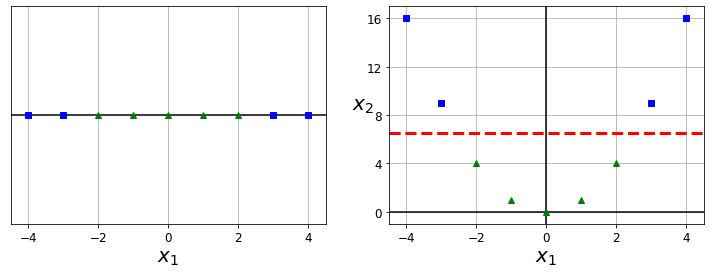

In [2]:
import numpy as np
import os

np.random.seed(42)

# To plot pretty figures
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


from sklearn.svm import SVC
from sklearn import datasets



X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
X2D = np.c_[X1D, X1D**2]
y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.plot(X1D[:, 0][y==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][y==1], np.zeros(5), "g^")
plt.gca().get_yaxis().set_ticks([])
plt.xlabel(r"$x_1$", fontsize=20)
plt.axis([-4.5, 4.5, -0.2, 0.2])

plt.subplot(122)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(X2D[:, 0][y==0], X2D[:, 1][y==0], "bs")
plt.plot(X2D[:, 0][y==1], X2D[:, 1][y==1], "g^")
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"$x_2$", fontsize=20, rotation=0)
plt.gca().get_yaxis().set_ticks([0, 4, 8, 12, 16])
plt.plot([-4.5, 4.5], [6.5, 6.5], "r--", linewidth=3)
plt.axis([-4.5, 4.5, -1, 17])
plt.subplots_adjust(right=1)
plt.show()

## The equations

Suppose we define a polynomial transformation of degree two only (we continue to live in a plane with $x_i$ and $y_i$ as variables)

$$
z = \phi(x_i) =\left(x_i^2, y_i^2, \sqrt{2}x_iy_i\right).
$$

With our new basis, the equations we solved earlier are basically the same, that is we have now (without the slack option for simplicity)

$$
{\cal L}=\sum_i\lambda_i-\frac{1}{2}\sum_{ij}^n\lambda_i\lambda_jy_iy_j\boldsymbol{z}_i^T\boldsymbol{z}_j,
$$

subject to the constraints $\lambda_i\geq 0$, $\sum_i\lambda_iy_i=0$, and for the support vectors

$$
y_i(\boldsymbol{w}^T\boldsymbol{z}_i+b)= 1 \hspace{0.1cm}\forall i,
$$

from which we also find $b$.
To compute $\boldsymbol{z}_i^T\boldsymbol{z}_j$ we define the kernel $K(\boldsymbol{x}_i,\boldsymbol{x}_j)$ as

$$
K(\boldsymbol{x}_i,\boldsymbol{x}_j)=\boldsymbol{z}_i^T\boldsymbol{z}_j= \phi(\boldsymbol{x}_i)^T\phi(\boldsymbol{x}_j).
$$

For the above example, the kernel reads

$$
K(\boldsymbol{x}_i,\boldsymbol{x}_j)=[x_i^2, y_i^2, \sqrt{2}x_iy_i]^T\begin{bmatrix} x_j^2 \\ y_j^2 \\ \sqrt{2}x_jy_j \end{bmatrix}=x_i^2x_j^2+2x_ix_jy_iy_j+y_i^2y_j^2.
$$

We note that this is nothing but the dot product of the two original
vectors $(\boldsymbol{x}_i^T\boldsymbol{x}_j)^2$. Instead of thus computing the
product in the Lagrangian of $\boldsymbol{z}_i^T\boldsymbol{z}_j$ we simply compute
the dot product $(\boldsymbol{x}_i^T\boldsymbol{x}_j)^2$.


This leads to the so-called
kernel trick and the result leads to the same as if we went through
the trouble of performing the transformation
$\phi(\boldsymbol{x}_i)^T\phi(\boldsymbol{x}_j)$ during the SVM calculations.


## The problem to solve
Using our definition of the kernel We can rewrite again the Lagrangian

$$
{\cal L}=\sum_i\lambda_i-\frac{1}{2}\sum_{ij}^n\lambda_i\lambda_jy_iy_j\boldsymbol{x}_i^T\boldsymbol{z}_j,
$$

subject to the constraints $\lambda_i\geq 0$, $\sum_i\lambda_iy_i=0$ in terms of a convex optimization problem

$$
\frac{1}{2} \boldsymbol{\lambda}^T\begin{bmatrix} y_1y_1K(\boldsymbol{x}_1,\boldsymbol{x}_1) & y_1y_2K(\boldsymbol{x}_1,\boldsymbol{x}_2) & \dots & \dots & y_1y_nK(\boldsymbol{x}_1,\boldsymbol{x}_n) \\
y_2y_1K(\boldsymbol{x}_2,\boldsymbol{x}_1) & y_2y_2(\boldsymbol{x}_2,\boldsymbol{x}_2) & \dots & \dots & y_1y_nK(\boldsymbol{x}_2,\boldsymbol{x}_n) \\
\dots & \dots & \dots & \dots & \dots \\
\dots & \dots & \dots & \dots & \dots \\
y_ny_1K(\boldsymbol{x}_n,\boldsymbol{x}_1) & y_ny_2K(\boldsymbol{x}_n\boldsymbol{x}_2) & \dots & \dots & y_ny_nK(\boldsymbol{x}_n,\boldsymbol{x}_n) \\
\end{bmatrix}\boldsymbol{\lambda}-\mathbb{1}\boldsymbol{\lambda},
$$

subject to $\boldsymbol{y}^T\boldsymbol{\lambda}=0$. Here we defined the vectors $\boldsymbol{\lambda} =[\lambda_1,\lambda_2,\dots,\lambda_n]$ and 
$\boldsymbol{y}=[y_1,y_2,\dots,y_n]$. 
If we add the slack constants this leads to the additional constraint $0\leq \lambda_i \leq C$.

We can rewrite this (see the solutions below) in terms of a convex optimization problem of the type

$$
\begin{align*}
    &\mathrm{min}_{\lambda}\hspace{0.2cm} \frac{1}{2}\boldsymbol{\lambda}^T\boldsymbol{P}\boldsymbol{\lambda}+\boldsymbol{q}^T\boldsymbol{\lambda},\\ \nonumber
    &\mathrm{subject\hspace{0.1cm}to} \hspace{0.2cm} \boldsymbol{G}\boldsymbol{\lambda} \preceq \boldsymbol{h} \hspace{0.2cm} \wedge \boldsymbol{A}\boldsymbol{\lambda}=f.
\end{align*}
$$

Below we discuss how to solve these equations. Here we note that the matrix $\boldsymbol{P}$ has matrix elements $p_{ij}=y_iy_jK(\boldsymbol{x}_i,\boldsymbol{x}_j)$.
Given a kernel $K$ and the targets $y_i$ this matrix is easy to set up. The constraint $\boldsymbol{y}^T\boldsymbol{\lambda}=0$ leads to $f=0$ and $\boldsymbol{A}=\boldsymbol{y}$. How to set up the matrix $\boldsymbol{G}$ is discussed later. Here note that the inequalities $0\leq \lambda_i \leq C$ can be split up into
$0\leq \lambda_i$ and $\lambda_i \leq C$. These two inequalities define then the matrix $\boldsymbol{G}$ and the vector $\boldsymbol{h}$.


## Different kernels and Mercer's theorem

There are several popular kernels being used. These are
1. Linear: $K(\boldsymbol{x},\boldsymbol{y})=\boldsymbol{x}^T\boldsymbol{y}$,

2. Polynomial: $K(\boldsymbol{x},\boldsymbol{y})=(\boldsymbol{x}^T\boldsymbol{y}+\gamma)^d$,

3. Gaussian Radial Basis Function: $K(\boldsymbol{x},\boldsymbol{y})=\exp{\left(-\gamma\vert\vert\boldsymbol{x}-\boldsymbol{y}\vert\vert^2\right)}$,

4. Tanh: $K(\boldsymbol{x},\boldsymbol{y})=\tanh{(\boldsymbol{x}^T\boldsymbol{y}+\gamma)}$,

and many other ones.

An important theorem for us is [Mercer's
theorem](https://en.wikipedia.org/wiki/Mercer%27s_theorem).  The
theorem states that if a kernel function $K$ is symmetric, continuous
and leads to a positive semi-definite matrix $\boldsymbol{P}$ then there
exists a function $\phi$ that maps $\boldsymbol{x}_i$ and $\boldsymbol{x}_j$ into
another space (possibly with much higher dimensions) such that

$$
K(\boldsymbol{x}_i,\boldsymbol{x}_j)=\phi(\boldsymbol{x}_i)^T\phi(\boldsymbol{x}_j).
$$

So you can use $K$ as a kernel since you know $\phi$ exists, even if
you don’t know what $\phi$ is. 

Note that some frequently used kernels (such as the Sigmoid kernel)
don’t respect all of Mercer’s conditions, yet they generally work well
in practice.


## The moons example

In [3]:
from __future__ import division, print_function, unicode_literals

import numpy as np
np.random.seed(42)

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


from sklearn.svm import SVC
from sklearn import datasets



from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC


from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=10, loss="hinge", random_state=42))
    ])

polynomial_svm_clf.fit(X, y)

def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

plt.show()


from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
    ])
poly_kernel_svm_clf.fit(X, y)

poly100_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=10, coef0=100, C=5))
    ])
poly100_kernel_svm_clf.fit(X, y)

plt.figure(figsize=(11, 4))

plt.subplot(121)
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title(r"$d=3, r=1, C=5$", fontsize=18)

plt.subplot(122)
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title(r"$d=10, r=100, C=5$", fontsize=18)

plt.show()

def gaussian_rbf(x, landmark, gamma):
    return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1)**2)

gamma = 0.3

x1s = np.linspace(-4.5, 4.5, 200).reshape(-1, 1)
x2s = gaussian_rbf(x1s, -2, gamma)
x3s = gaussian_rbf(x1s, 1, gamma)

XK = np.c_[gaussian_rbf(X1D, -2, gamma), gaussian_rbf(X1D, 1, gamma)]
yk = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.scatter(x=[-2, 1], y=[0, 0], s=150, alpha=0.5, c="red")
plt.plot(X1D[:, 0][yk==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][yk==1], np.zeros(5), "g^")
plt.plot(x1s, x2s, "g--")
plt.plot(x1s, x3s, "b:")
plt.gca().get_yaxis().set_ticks([0, 0.25, 0.5, 0.75, 1])
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"Similarity", fontsize=14)
plt.annotate(r'$\mathbf{x}$',
             xy=(X1D[3, 0], 0),
             xytext=(-0.5, 0.20),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.text(-2, 0.9, "$x_2$", ha="center", fontsize=20)
plt.text(1, 0.9, "$x_3$", ha="center", fontsize=20)
plt.axis([-4.5, 4.5, -0.1, 1.1])

plt.subplot(122)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(XK[:, 0][yk==0], XK[:, 1][yk==0], "bs")
plt.plot(XK[:, 0][yk==1], XK[:, 1][yk==1], "g^")
plt.xlabel(r"$x_2$", fontsize=20)
plt.ylabel(r"$x_3$  ", fontsize=20, rotation=0)
plt.annotate(r'$\phi\left(\mathbf{x}\right)$',
             xy=(XK[3, 0], XK[3, 1]),
             xytext=(0.65, 0.50),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.plot([-0.1, 1.1], [0.57, -0.1], "r--", linewidth=3)
plt.axis([-0.1, 1.1, -0.1, 1.1])
    
plt.subplots_adjust(right=1)

plt.show()


x1_example = X1D[3, 0]
for landmark in (-2, 1):
    k = gaussian_rbf(np.array([[x1_example]]), np.array([[landmark]]), gamma)
    print("Phi({}, {}) = {}".format(x1_example, landmark, k))

rbf_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))
    ])
rbf_kernel_svm_clf.fit(X, y)


from sklearn.svm import SVC

gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
        ])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

plt.figure(figsize=(11, 7))

for i, svm_clf in enumerate(svm_clfs):
    plt.subplot(221 + i)
    plot_predictions(svm_clf, [-1.5, 2.5, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)

plt.show()

## Mathematical optimization of convex functions

A mathematical (quadratic) optimization problem, or just optimization problem, has the form

$$
\begin{align*}
    &\mathrm{min}_{\lambda}\hspace{0.2cm} \frac{1}{2}\boldsymbol{\lambda}^T\boldsymbol{P}\boldsymbol{\lambda}+\boldsymbol{q}^T\boldsymbol{\lambda},\\ \nonumber
    &\mathrm{subject\hspace{0.1cm}to} \hspace{0.2cm} \boldsymbol{G}\boldsymbol{\lambda} \preceq \boldsymbol{h} \wedge  \boldsymbol{A}\boldsymbol{\lambda}=f.
\end{align*}
$$

subject to some constraints for say a selected set $i=1,2,\dots, n$.
In our case we are optimizing with respect to the Lagrangian multipliers $\lambda_i$, and the
vector $\boldsymbol{\lambda}=[\lambda_1, \lambda_2,\dots, \lambda_n]$ is the optimization variable we are dealing with.

In our case we are particularly interested in a class of optimization problems called convex optmization problems. 
In our discussion on gradient descent methods we discussed at length the definition of a convex function. 

Convex optimization problems play a central role in applied mathematics and we recommend strongly [Boyd and Vandenberghe's text on the topics](http://web.stanford.edu/~boyd/cvxbook/).



## How do we solve these problems?

If we use Python as programming language and wish to venture beyond
**scikit-learn**, **tensorflow** and similar software which makes our
lives so much easier, we need to dive into the wonderful world of
quadratic programming. We can, if we wish, solve the minimization
problem using say standard gradient methods or conjugate gradient
methods. However, these methods tend to exhibit a rather slow
converge. So, welcome to the promised land of quadratic programming.

The functions we need are contained in the quadratic programming package **CVXOPT** and we need to import it together with **numpy** as

In [4]:
import numpy
import cvxopt

This will make our life much easier. You don't need t write your own optimizer.


## A simple example

We remind ourselves about the general problem we want to solve

$$
\begin{align*}
    &\mathrm{min}_{x}\hspace{0.2cm} \frac{1}{2}\boldsymbol{x}^T\boldsymbol{P}\boldsymbol{x}+\boldsymbol{q}^T\boldsymbol{x},\\ \nonumber
    &\mathrm{subject\hspace{0.1cm} to} \hspace{0.2cm} \boldsymbol{G}\boldsymbol{x} \preceq \boldsymbol{h} \wedge  \boldsymbol{A}\boldsymbol{x}=f.
\end{align*}
$$

Let us show how to perform the optmization using a simple case. Assume we want to optimize the following problem

$$
\begin{align*}
    &\mathrm{min}_{x}\hspace{0.2cm} \frac{1}{2}x^2+5x+3y \\ \nonumber
    &\mathrm{subject to} \\ \nonumber
    &x, y \geq 0 \\ \nonumber
    &x+3y  \geq 15 \\ \nonumber
    &2x+5y  \leq  100 \\ \nonumber
    &3x+4y  \leq  80.  \\ \nonumber
\end{align*}
$$

The minimization problem can be rewritten in terms of vectors and matrices as (with $x$ and $y$ being the unknowns)

$$
\frac{1}{2}\begin{bmatrix} x\\ y \end{bmatrix}^T   \begin{bmatrix} 1 & 0\\ 0 & 0  \end{bmatrix}  \begin{bmatrix} x \\ y \end{bmatrix}  + \begin{bmatrix}3\\ 4  \end{bmatrix}^T \begin{bmatrix}x \\ y  \end{bmatrix}.
$$

Similarly, we can now set up the inequalities (we need to change $\geq$ to $\leq$ by multiplying with $-1$ on bot sides) as the following matrix-vector equation

$$
\begin{bmatrix} -1 & 0 \\ 0 & -1 \\ -1 & -3 \\ 2 & 5 \\ 3 & 4\end{bmatrix}\begin{bmatrix} x \\ y\end{bmatrix} \preceq \begin{bmatrix}0 \\ 0\\ -15 \\ 100 \\ 80\end{bmatrix}.
$$

We have collapsed all the inequalities into a single matrix $\boldsymbol{G}$. We see also that our matrix

$$
\boldsymbol{P} =\begin{bmatrix} 1 & 0\\ 0 & 0  \end{bmatrix}
$$

is clearly positive semi-definite (all eigenvalues larger or equal zero). 
Finally, the vector $\boldsymbol{h}$ is defined as

$$
\boldsymbol{h} = \begin{bmatrix}0 \\ 0\\ -15 \\ 100 \\ 80\end{bmatrix}.
$$

Since we don't have any equalities the matrix $\boldsymbol{A}$ is set to zero
The following code solves the equations for us

In [5]:
# Import the necessary packages
import numpy
from cvxopt import matrix
from cvxopt import solvers
P = matrix(numpy.diag([1,0]), tc=’d’)
q = matrix(numpy.array([3,4]), tc=’d’)
G = matrix(numpy.array([[-1,0],[0,-1],[-1,-3],[2,5],[3,4]]), tc=’d’)
h = matrix(numpy.array([0,0,-15,100,80]), tc=’d’)
# Construct the QP, invoke solver
sol = solvers.qp(P,q,G,h)
# Extract optimal value and solution
sol[’x’] 
sol[’primal objective’]

## Back to the more realistic cases

We are now ready to return to our setup of the optmization problem for a more realistic case. Introducing the **slack** parameter $C$ we have

$$
\frac{1}{2} \boldsymbol{\lambda}^T\begin{bmatrix} y_1y_1K(\boldsymbol{x}_1,\boldsymbol{x}_1) & y_1y_2K(\boldsymbol{x}_1,\boldsymbol{x}_2) & \dots & \dots & y_1y_nK(\boldsymbol{x}_1,\boldsymbol{x}_n) \\
y_2y_1K(\boldsymbol{x}_2,\boldsymbol{x}_1) & y_2y_2K(\boldsymbol{x}_2,\boldsymbol{x}_2) & \dots & \dots & y_1y_nK(\boldsymbol{x}_2,\boldsymbol{x}_n) \\
\dots & \dots & \dots & \dots & \dots \\
\dots & \dots & \dots & \dots & \dots \\
y_ny_1K(\boldsymbol{x}_n,\boldsymbol{x}_1) & y_ny_2K(\boldsymbol{x}_n\boldsymbol{x}_2) & \dots & \dots & y_ny_nK(\boldsymbol{x}_n,\boldsymbol{x}_n) \\
\end{bmatrix}\boldsymbol{\lambda}-\mathbb{I}\boldsymbol{\lambda},
$$

subject to $\boldsymbol{y}^T\boldsymbol{\lambda}=0$. Here we defined the vectors $\boldsymbol{\lambda} =[\lambda_1,\lambda_2,\dots,\lambda_n]$ and 
$\boldsymbol{y}=[y_1,y_2,\dots,y_n]$. 
With  the slack constants this leads to the additional constraint $0\leq \lambda_i \leq C$.